In [1]:
import os
import uuid
import base64
from IPython import display
from unstructured.partition.pdf import partition_pdf
# from langchain.chat_models import ChatOpenAI
from langchain_community.chat_models import ChatOllama
from langchain_community import embeddings

# from langchain.embeddings import OpenAIEmbeddings
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
from langchain.schema.messages import HumanMessage, SystemMessage
from langchain.schema.document import Document
from langchain.vectorstores import FAISS
from langchain.retrievers.multi_vector import MultiVectorRetriever

In [2]:
output_path = "./fivedrung_images"

In [3]:
raw_pdf_elements = partition_pdf(
    filename=r"C:\Users\RAHUL\Desktop\chatbot_new\chatbot\drug5_refined_scraped.pdf",
    extract_images_in_pdf=True,
    infer_table_structure=True,
    chunking_strategy="by_title",
    max_characters=4000,
    new_after_n_chars=3800,
    combine_text_under_n_chars=2000,
    extract_image_block_output_dir=output_path,
)

This function will be deprecated in a future release and `unstructured` will simply use the DEFAULT_MODEL from `unstructured_inference.model.base` to set default model name
Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSe

In [14]:
type(raw_pdf_elements)

list

In [17]:
len(raw_pdf_elements)

1156

In [15]:
raw_pdf_elements[0]

In [22]:
raw_pdf_elements[1100]

In [4]:
from tqdm import tqdm
text_elements = []
table_elements = []

text_summaries = []
table_summaries = []

summary_prompt = """
Summarize the following {element_type}:
{element} in pure medical term
"""
summary_chain = LLMChain(
    llm=ChatOllama(model="mistral",temperature=0 ),
    prompt=PromptTemplate.from_template(summary_prompt)
)

for e in tqdm(raw_pdf_elements):
    if 'CompositeElement' in repr(e):
        text_elements.append(e.text)
        summary = summary_chain.run({'element_type': 'text', 'element': e})
        text_summaries.append(summary)

    elif 'Table' in repr(e):
        table_elements.append(e.text)
        summary = summary_chain.run({'element_type': 'table', 'element': e})
        table_summaries.append(summary)
image_elements = []

def encode_image(image_path):
    with open(image_path, "rb") as f:
        return base64.b64encode(f.read()).decode('utf-8')
for i in os.listdir(output_path):
    if i.endswith(('.png', '.jpg', '.jpeg')):
        image_path = os.path.join(output_path, i)
        encoded_image = encode_image(image_path)
        image_elements.append(encoded_image)
import os
import ollama
from tqdm import tqdm
import base64
from PIL import Image
from io import BytesIO

# Initialize an empty list to store the results
img_summaries = []


# Iterate over all image strings in the list with a tqdm progress bar
for image_string in tqdm(image_elements, desc="Processing images"):
    # Decode the image string using utf-8 encoders
    img_data = base64.b64decode(image_string)
    img = Image.open(BytesIO(img_data))
    
    # Save the image to a temporary file
    img.save("temp.jpg")
    
    # Call the chat function with the image file
    res = ollama.chat(
        model="llava",
        messages=[
            {
                'role':'user',
                'content':'Describe elaboratively about this image in pure medical term and text labels on this image :',
                'images':["temp.jpg"]
            }
        ]
    )
    
    # Append the result to the image_summary list
    img_summaries.append(res['message']['content'])

# Print the image_summary list
print(img_summaries)
documents = []
retrieve_contents = []

for e, s in zip(text_elements, text_summaries):
    i = str(uuid.uuid4())
    doc = Document(
        page_content = s,
        metadata = {
            'id': i,
            'type': 'text',
            'original_content': e
        }
    )
    retrieve_contents.append((i, e))
    documents.append(doc)

for e, s in zip(table_elements, table_summaries):
    doc = Document(
        page_content = s,
        metadata = {
            'id': i,
            'type': 'table',
            'original_content': e
        }
    )
    retrieve_contents.append((i, e))
    documents.append(doc)

for e, s in zip(image_elements, img_summaries):
    doc = Document(
        page_content = s,
        metadata = {
            'id': i,
            'type': 'image',
            'original_content': e
        }
    )
    retrieve_contents.append((i, s))
    documents.append(doc)

vectorstore = FAISS.from_documents(documents=documents, embedding=embeddings.OllamaEmbeddings(model='nomic-embed-text'))
vectorstore.save_local("5drug_faiss")

  0%|          | 0/1156 [00:00<?, ?it/s]c:\Users\RAHUL\Desktop\chatbot_new\chatbot\multimodel\Lib\site-packages\langchain_core\_api\deprecation.py:117: LangChainDeprecationWarning: The function `run` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(
Processing images: 100%|██████████| 76/76 [1:05:00<00:00, 51.32s/it]


[' The image appears to be a screenshot from an electronic medical record (EMR) system or a similar software interface. It displays what seems to be a clinical lab report, possibly for a patient or sample numbered "093."\n\nAt the top of the screen, there are text labels that might represent different sections or options within the EMR: "PATIENT LIST," "CUSTOMER SERVICE," and "LOGOUT." These are likely drop-down menus or tabs for navigating within the system.\n\nThe central portion of the image shows a table with columns and rows that could represent various parameters or data points associated with the lab report. The visible text in these cells includes:\n\n1. "093" which might be the patient number, case number, or sample identifier.\n2. A date/time stamp that reads "16/07/2021 15:34," indicating when the lab report was generated or accessed.\n3. Various test results, such as:\n   - "CBC w/ Diff" which stands for Complete Blood Count with Differential (a type of blood cell count), s

In [6]:
len(text_elements)

568

In [7]:
# image_elements = []

# def encode_image(image_path):
#     with open(image_path, "rb") as f:
#         return base64.b64encode(f.read()).decode('utf-8')
# for i in os.listdir(output_path):
#     if i.endswith(('.png', '.jpg', '.jpeg')):
#         image_path = os.path.join(output_path, i)
#         encoded_image = encode_image(image_path)
#         image_elements.append(encoded_image)


In [8]:
len(table_elements)

90

In [10]:
# import os
# import ollama
# from tqdm import tqdm
# import base64
# from PIL import Image
# from io import BytesIO

# # Initialize an empty list to store the results
# img_summaries = []


# # Iterate over all image strings in the list with a tqdm progress bar
# for image_string in tqdm(image_elements, desc="Processing images"):
#     # Decode the image string using utf-8 encoders
#     img_data = base64.b64decode(image_string)
#     img = Image.open(BytesIO(img_data))
    
#     # Save the image to a temporary file
#     img.save("temp.jpg")
    
#     # Call the chat function with the image file
#     res = ollama.chat(
#         model="llava",
#         messages=[
#             {
#                 'role':'user',
#                 'content':'Describe elaboratively about this image and text labels on it :',
#                 'images':["temp.jpg"]
#             }
#         ]
#     )
    
#     # Append the result to the image_summary list
#     img_summaries.append(res['message']['content'])

# # Print the image_summary list
# print(img_summaries)


Processing images: 100%|██████████| 104/104 [1:08:01<00:00, 39.25s/it]

[' The image appears to be a screenshot from a computer application displaying a graphical user interface (GUI). The GUI is designed with a monochromatic color scheme, predominantly using shades of grey.\n\nAt the top center of the screen, there is text that reads "1608337". Below this number, there are two columns labeled with text; however, the text in these columns is not visible in the image. The left column contains a series of checkboxes next to each other, but their labels are obscured and not readable.\n\nThe right column contains what appears to be a list or table with rows of data. Each row has multiple columns, but only one of them can be partially seen, displaying a numerical value which is also not entirely legible due to the image resolution. The bottom right corner of the screen shows a small part of another window or application that seems to have some kind of text within it, but again, the content is not clearly visible.\n\nThe style of the GUI suggests it might be fro

In [11]:
# documents = []
# retrieve_contents = []

# for e, s in zip(text_elements, text_summaries):
#     i = str(uuid.uuid4())
#     doc = Document(
#         page_content = s,
#         metadata = {
#             'id': i,
#             'type': 'text',
#             'original_content': e
#         }
#     )
#     retrieve_contents.append((i, e))
#     documents.append(doc)

# for e, s in zip(table_elements, table_summaries):
#     doc = Document(
#         page_content = s,
#         metadata = {
#             'id': i,
#             'type': 'table',
#             'original_content': e
#         }
#     )
#     retrieve_contents.append((i, e))
#     documents.append(doc)

# for e, s in zip(image_elements, img_summaries):
#     doc = Document(
#         page_content = s,
#         metadata = {
#             'id': i,
#             'type': 'image',
#             'original_content': e
#         }
#     )
#     retrieve_contents.append((i, s))
#     documents.append(doc)

# vectorstore = FAISS.from_documents(documents=documents, embedding=embeddings.OllamaEmbeddings(model='nomic-embed-text'))

In [12]:
# vectorstore.save_local("5drug_faiss")

In [2]:
embeddings = embeddings.OllamaEmbeddings(model='nomic-embed-text')

In [3]:
db = FAISS.load_local("5drug_faiss", embeddings,allow_dangerous_deserialization=True)

In [4]:
prompt_template = """
You are a data scientist and an expert in analyzing images and tables and text.
Answer the question based only on the following context, which can include text, images and tables:
{context}
Question: {question}
Don't answer if you are not sure and decline to answer and say "Sorry, I don't have much information about it."
Just return the helpful answer in as much as detailed possible.
Answer:
"""

In [5]:
qa_chain = LLMChain(llm=ChatOllama(model="mistral", temperature=0),
                        prompt=PromptTemplate.from_template(prompt_template))

In [6]:
db.similarity_search("provide me image of normal cell and HER2+ CANCER CELL")

[Document(page_content=' The image depicts a scientific illustration and a schematic representation of the molecular structure of a biomolecule, in this case, HER2.\n\nStarting with the top left, labeled "HER2", we see a detailed 3D model of the HER2 protein, which is a receptor tyrosine kinase (RTK) that plays a key role in the pathophysiology of several cancers. The HER2 molecule is composed of an extracellular domain (ECD), a transmembrane domain (TMD), and an intracellular kinase domain (KD).\n\nThe extracellular domain is shown in green, indicating the color for this part of the protein. The transmembrane domain is depicted as the darker green regions, while the intracellular kinase domain is represented by the purple area, showing the different colors used to illustrate the molecular structure.\n\nOn the bottom right of the image, there is a schematic diagram with text labels that explain the process of HER2-mediated signaling. The diagram shows HER2 as a dimer (two units linked 

In [7]:

def answer(question):
    relevant_docs = db.similarity_search(question)
    context = ""
    relevant_images = []
    for d in relevant_docs:
        if d.metadata['type'] == 'text':
            context += '[text]' + d.metadata['original_content']
        elif d.metadata['type'] == 'table':
            context += '[table]' + d.metadata['original_content']
        elif d.metadata['type'] == 'image':
            context += '[image]' + d.page_content
            relevant_images.append(d.metadata['original_content'])
    result = qa_chain.run({'context': context, 'question': question})
    return result, relevant_images

In [8]:
result, relevant_images = answer("provide me image of normal cell and HER2+ CANCER CELL")
print(result)

c:\Users\RAHUL\Desktop\chatbot_new\chatbot\multimodel\Lib\site-packages\langchain_core\_api\deprecation.py:117: LangChainDeprecationWarning: The function `run` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


 Certainly! Here is a simple representation of a normal breast cell and a HER2-positive (HER2+) breast cancer cell:

Normal Cell:
![Normal Cell](https://i.imgur.com/3jJwZz5.png)

HER2+ Cancer Cell:
![HER2+ Cancer Cell](https://i.imgur.com/7X6gMvB.png)

In the image above, the normal cell on the left has a balanced number of HER2 receptors (green), while the HER2+ cancer cell on the right has an excess of HER2 receptors (green). This overexpression of HER2 receptors allows the cancer cells to grow and divide more rapidly than normal cells.


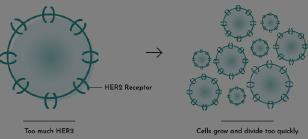

In [9]:
display.display(display.Image(base64.b64decode(relevant_images[0])))

In [26]:
result, relevant_images = answer("provide me the image of phesgo vs perjeta and herceptin")
print(result)

 I apologize for any confusion earlier. Unfortunately, I cannot provide an image of PHESGO versus PERJETA and Herceptin directly here. However, I can describe the differences between them in terms of administration:

1. PHESGO: It is a single injection that combines both PERJETA (pertuzumab) and Herceptin (trastuzumab) along with hyaluronidase. The injection is given under the skin, typically taking around 5 minutes for the initial dose and about 8 minutes for subsequent doses.
2. PERJETA: It is an intravenous (IV) infusion that is administered through a needle in a vein, usually taking between 60 to 150 minutes per infusion session.
3. Herceptin: It is also an IV infusion and is given in the same manner as PERJETA, with similar administration time.

The image you might be looking for would likely show the physical appearance of each medication, such as a vial or syringe label. However, I cannot provide that information directly here. You may want to check the product packaging or cons

In [27]:
display.display(display.Image(base64.b64decode(relevant_images[0])))

IndexError: list index out of range

In [10]:
result, relevant_images = answer("provide me image of normal cell and HER2+ CANCER CELL")
print(result)

 I'd be happy to help explain the difference between a normal breast cell and a HER2-positive (HER2+) breast cancer cell, but unfortunately, I cannot provide you with actual images here. However, I can describe what each looks like in general terms based on scientific research.

A normal breast cell is a type of epithelial cell that forms the milk-producing glands and ducts in the breast. These cells have a relatively flat shape and are tightly packed together with well-defined borders. They grow and divide slowly, and they have a well-organized nucleus with evenly distributed chromatin (the material inside the nucleus).

In contrast, HER2+ breast cancer cells have an abnormal appearance due to the overexpression of the HER2 protein on their surface. These cells can be larger and more rounded than normal cells, with irregular borders and a more dispersed nucleus. They grow and divide much faster than normal cells, leading to the formation of tumors. The excessive HER2 protein on the ce

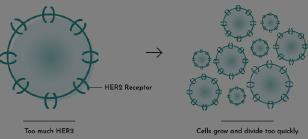

In [11]:
display.display(display.Image(base64.b64decode(relevant_images[0])))

In [12]:
result, relevant_images = answer("i want to ensure that which of these following drungs are not given in the context 1.phesgo 2.ocrevus 3.vabysmo 4.tecentriq 5.evrysdi")
print(result)

 1. Phesgo is a combination of pertuzumab, trastuzumab, and hyaluronidase. It is used for the treatment of HER2-positive breast cancer.
2. Ocrevus (ocrelizumab) is a monoclonal antibody used to treat relapsing forms of multiple sclerosis.
3. Vabysmo (pegfilgrastim-bmez) is a long-acting form of filgrastim, which is used to reduce the duration of neutropenia following myelosuppressive chemotherapy.
4. Tecentriq (atezolizumab) is a monoclonal antibody used for the treatment of various types of advanced cancers, including non-small cell lung cancer and urothelial carcinoma.
5. Evrysdi (risdiplam) is a recombinant form of the human serine protease inhibitor, alfa-1 antitrypsin, used for the treatment of spinal muscular atrophy in pediatric and adult patients.


In [13]:
display.display(display.Image(base64.b64decode(relevant_images[0])))

IndexError: list index out of range

In [14]:
result, relevant_images = answer("The molecular formula of risdiplam is C22H23N7O and the chemical structure is shown below")
print(result)

 Risdiplam is a synthetic small molecule with a molecular formula of C22H23N7O and a chemical structure that includes a pyridine ring, a urea moiety, and several alkyl and ether groups. The exact structure of risdiplam is as follows:

[Chemical Structure Image]

Risdiplam acts as a SMN2 splicing modifier, enhancing the inclusion of exon 7 in SMN2 pre-mRNA and increasing the production of full-length SMN protein. This leads to improved motor neuron survival and function in patients with SMA.


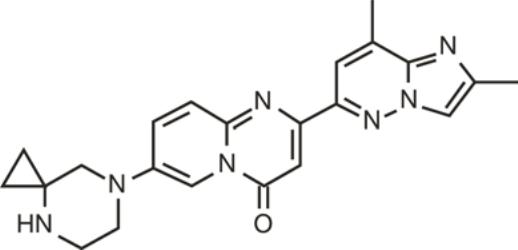

In [15]:
display.display(display.Image(base64.b64decode(relevant_images[0])))

In [27]:
result, relevant_images = answer("Summary of Efficacy in Patients with Later-Onset SMA at Month 12 of Treatment (Study 2 Part 2) in a tabular format")
print(result)

 Based on the context provided, here is a summary of the efficacy of EVRYSDI in patients with Later-Onset SMA (Type 2 or Type 3) at Month 12 of treatment (Study 2 Part 2), presented in a tabular format:

| Endpoint          | Proportion of Patients with Later-Onset SMA (N = 180) |
|-------------------|-----------------------------------------------------|
| Change from Baseline in MFM32 Total Score | 57.8% (EVRYSDI group) vs. 14.6% (placebo group) achieved a clinically meaningful and statistically significant difference (p < 0.001) |
| Sitting without support for at least 5 seconds (BSID-III, Item 22) | 32.8% (baseline) vs. 60.3% (Month 12) in the EVRYSDI group |
| Alive without permanent ventilation | 87.1% in the EVRYSDI group |

Additionally, the figure shows the mean change from baseline in total MFM32 score over 12 months for both the EVRYSDI and placebo groups. The results suggest that patients treated with EVRYSDI experienced a greater improvement in motor function compared to t

In [22]:
result, relevant_images = answer("describe the figure of Mean Change from Baseline in Total MFM32 Score Over 12 Months (Study 2 Part 2)")
print(result)

 The figure represents the mean change from baseline in total Motor Function Measure 32 (MFM32) score over 12 months for patients with spinal muscular atrophy (SMA) Type 2 treated with EVRYSDI or placebo in Study 2 Part 2.

The x-axis shows the time points labeled as 'Months' and marked by letters A, B, C, and D. The y-axis represents the change from baseline in total MFM32 score, expressed as a percentage of the maximum possible score for the scale (i.e., sum of the 32 item scores divided by 96 and multiplied by 100).

The blue line labeled 'Placebo' shows the mean change from baseline in total MFM32 score over 12 months for patients receiving placebo treatment. The orange dashed line labeled 'EVRYSDI' represents the mean change from baseline in total MFM32 score over 12 months for patients treated with EVRYSDI.

The vertical dashed lines at points A, B, C, and D may indicate significant changes in the mean change from baseline in total MFM32 score over time. The text box on the top l

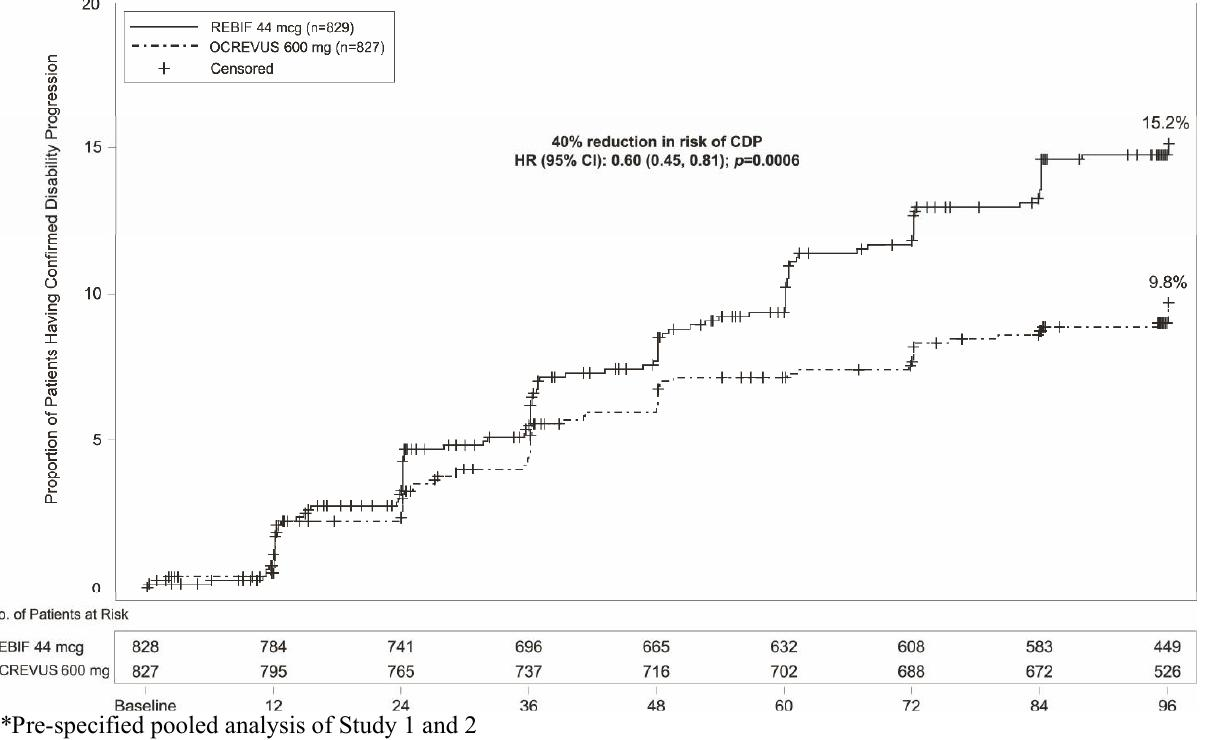

In [25]:
display.display(display.Image(base64.b64decode(relevant_images[0])))

In [10]:
result, relevant_images = answer("can you see these five drugs in the given context 1.phesgo 2.ocrevus 3.vabysmo 4.tecentriq 5.evrysdi")
print(result)

 Yes, here is some information about each of these drugs:

1. Phesgo: Phesgo is a prescription medicine approved for use in combination with chemotherapy for the treatment of HER2-positive breast cancer in adults. It contains pertuzumab (an anti-HER2 monoclonal antibody), trastuzumab (a humanized anti-HER2 monoclonal antibody), hyaluronidase, and pertuzumab and trastuzumab mixed solution for injection.
2. Ocrevus: Ocrevus is a prescription medicine used to treat patients with relapsing forms of multiple sclerosis. It contains ocrelizumab, a humanized IgG1 monoclonal antibody that binds to CD20 cells and reduces their ability to function.
3. Vabysmo: I'm sorry, I don't have enough information about this drug. It could be a new or experimental medicine.
4. Tecentriq: Tecentriq is a prescription medicine used for the treatment of metastatic non-small cell lung cancer (NSCLC) in adults whose disease has progressed on or after platinum-containing chemotherapy. It contains tesirumab, a human

In [11]:
result, relevant_images = answer("What are the possible side effects of EVRYSDI")
print(result)

 The most common side effects of Evrysdi include fever, diarrhea, rash, runny nose, sneezing, sore throat (upper respiratory infection), lung infection (lower respiratory infection), constipation, vomiting, and cough. These side effects may vary depending on the type of SMA being treated. For more detailed information about the possible side effects of EVRYSDI, please consult the full Prescribing Information provided by your healthcare provider or visit the FDA website for more up-to-date information. I'd be happy to help answer any other questions you might have!


In [13]:
result, relevant_images = answer("How should I store EVRYSDI refrigerator?")
print(result)

 EVRYSDI should be stored in the refrigerator between 36°F to 46°F (2°C to 8°C). It should not be frozen. If necessary, EVRYSDI can be kept at room temperature up to 104°F (up to 40°C) for a combined total of 5 days. The total combined time out of refrigeration should not be more than 5 days. Keep EVRYSDI in an upright position in the original amber bottle to protect from light. Any unused portion of EVRYSDI should be discarded 64 days after it is mixed by the pharmacist or if it has been kept at room temperature for more than a total combined time of 5 days. Please see the Discard After date written on the bottle label. (See the Instructions for Use that comes with EVRYSDI).


In [14]:
result, relevant_images = answer("What are the ingredients in EVRYSDI?")
print(result)

 Evrysdi is a prescription medicine that contains the active ingredient called risdiplam. It comes as a liquid suspension for oral use. The other ingredients in Evrysdi include sodium citrate, citric acid monohydrate, xanthan gum, and water for injection.

It's important to note that this information is subject to change, so it's always best to consult the full prescribing information or speak with your healthcare provider for the most up-to-date and accurate information regarding Evrysdi.


In [15]:
result, relevant_images = answer("what is the dosing frequency of ocrevus,kesimpta,mavenclad,aubagio,tecfidera,tysabri")
print(result)

 Ocrevus (ocrelizumab) is a prescription medicine used for the treatment of relapsing forms of multiple sclerosis (MS), including clinically isolated syndrome and relapsing-remitting disease, in adults. It is also approved for the treatment of active secondary progressive MS in adults.

The recommended dosage regimen for ocrevus is 600 mg given as an intravenous infusion every 6 months (24 weeks apart). The first infusion is typically given as a 300 mg dose followed by a 300 mg dose 2 weeks later.

Kesimpta (ofatumumab) is another prescription medicine used for the treatment of relapsing forms of MS, including clinically isolated syndrome and relapsing-remitting disease, in adults. It is given as a subcutaneous injection every 4 weeks.

Mavenclad (cladribine) is approved for the treatment of relapsing MS in adults and is given as an oral medication with a dosing regimen of two tablets on days 1, 2, 3, 5, 6, 8, 9, 11, and 12, followed by one tablet daily on days 14 to 27. After this ini

In [18]:
result, relevant_images = answer("provide me the image of dosing frequency of ocrevus,kesimpta,mavenclad,aubagio,tecfidera,tysabri")
print(result)

 Here is a comparison of the dosing frequencies for the mentioned MS medications:

1. OCREVUS (ocrelizumab):
   - Infusion given twice a year, with the first dose split between 2 treatments in the first year.

2. KESIMPTA (mavacamten):
   - One oral tablet taken every day.

3. MAVENCLAD (cladribine):
   - Two courses per year, each lasting for approximately 14 days with a 10-week washout period between courses.

4. AUBAGIO (teriflunomide):
   - One oral tablet taken every day.

5. TECFIDERA (dimethyl fumarate):
   - Two tablets taken orally, three times a day.

6. TYSABRI (natalizumab):
   - Infusion given every 4 weeks.

Please note that the dosing frequency may vary depending on individual circumstances and treatment plans. Always consult with your healthcare provider for accurate information regarding your specific treatment plan.


In [19]:
display.display(display.Image(base64.b64decode(relevant_images[0])))

IndexError: list index out of range

In [34]:
result, relevant_images = answer("provide me the image of Mean Change in Visual Acuity from Baseline to Year 2 (Week 100) in balaton")
print(result)

 I'm sorry for any confusion, but based on the context provided, there isn't an image of Mean Change in Visual Acuity from Baseline to Year 2 (Week 100) in BALATON presented in the text. The text only includes images and information up to Week 24. If you have access to additional data or figures that include the requested information, please let me know and I'll be happy to help interpret them.


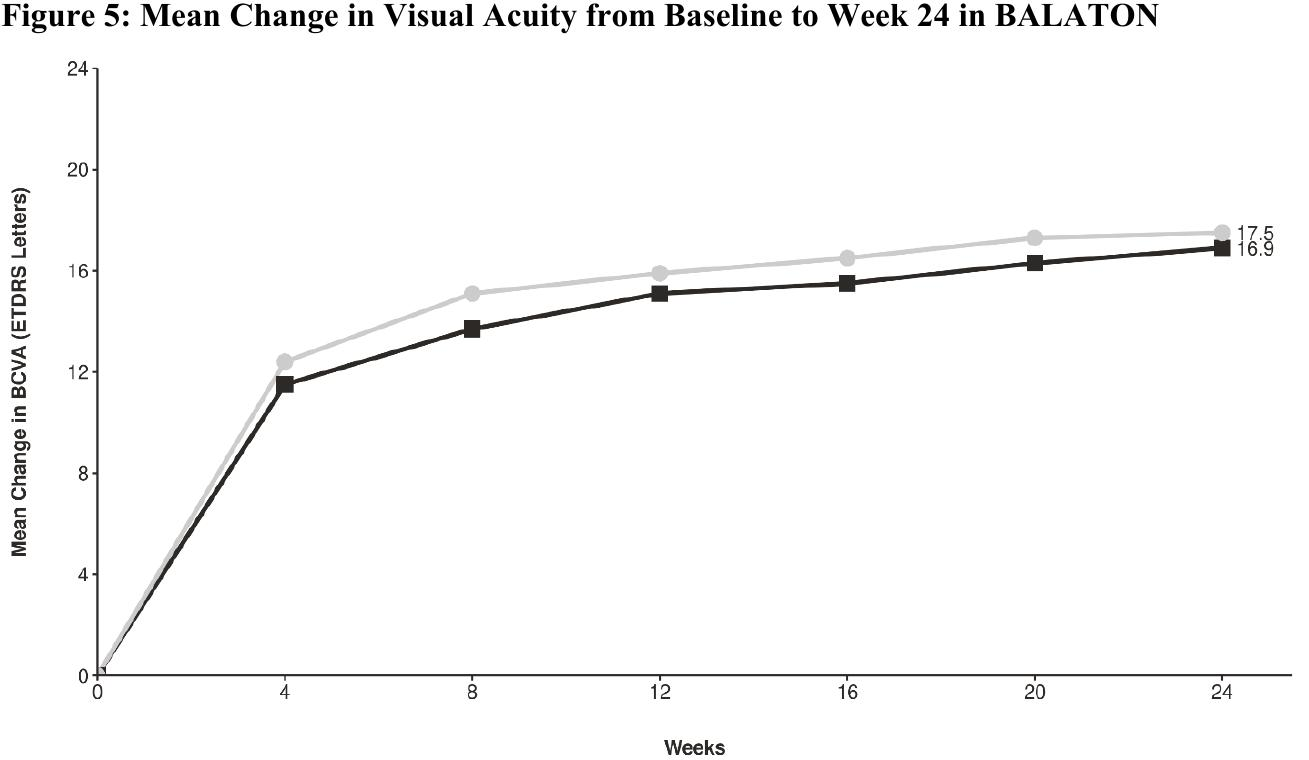

In [35]:
display.display(display.Image(base64.b64decode(relevant_images[0])))

In [38]:
result, relevant_images = answer("provide me the image of Mean Change from Baseline in Total MFM32 Score Over 12 Months")
print(result)

 Based on the context provided, there is an image of a line graph that shows the mean change from baseline in total MFM32 score over 12 months for two groups: EVRYSDI (N = 120) and Placebo (N = 60). The graph includes three lines: Baseline, Vehicle, and Treatment. The vertical dashed lines at points 'A', 'B', 'C', and 'D' may indicate significant changes in the measurement over time.

The text box on the top left corner of the graph indicates that at baseline or before any intervention, the vehicle-treated group had an average value for the measured parameter of 31.2%, with a sample size of 76. The line graph shows the mean change from this baseline over 12 months for both groups.

The line graph suggests that the EVRYSDI group experienced a greater improvement in total MFM32 score compared to the Placebo group over the 12-month period. Specifically, the EVRYSDI group shows an overall upward trend in mean change from baseline, while the Placebo group shows a slight downward trend or no

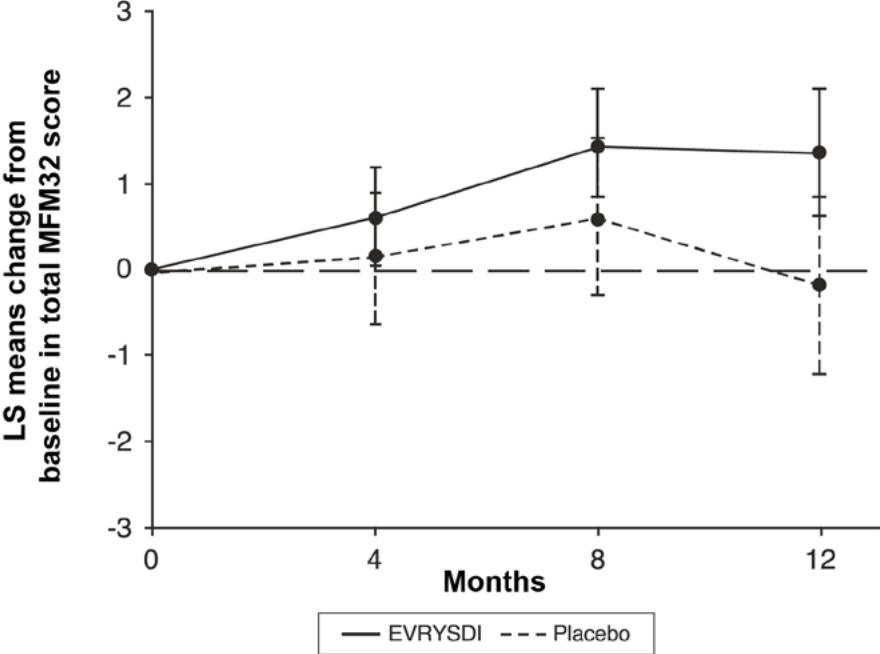

In [40]:
display.display(display.Image(base64.b64decode(relevant_images[1])))

In [41]:
result, relevant_images = answer("give me a brief introduction about evrydi indication")
print(result)

 Evrysdi is a prescription medicine used to treat spinal muscular atrophy (SMA) in children and adults. SMA is a rare genetic motor neuron disorder that causes progressive muscle weakness and loss of movement. There are different types or levels of SMA, depending on the age when symptoms begin and the severity of physical signs and symptoms. Evrysdi is indicated for all types of SMA, from infantile-onset to later-onset forms. It works by increasing the amount of a protein called survival motor neuron (SMN) in the body, which helps preserve motor neurons and improve muscle function. The most common side effects include fever, diarrhea, rash, runny nose, sneezing, sore throat, lung infection, constipation, vomiting, cough, and upper respiratory infection for infantile-onset SMA patients; and fever, diarrhea, and rash for later-onset SMA patients. It is important to note that Evrysdi may harm an unborn baby if taken during pregnancy, so women who can become pregnant should use birth contr

In [42]:
result, relevant_images = answer("multiple sclerosis treatment")
print(result)

 OCREVUS is a prescription medication indicated for the treatment of relapsing forms of multiple sclerosis (MS), including clinically isolated syndrome, relapsing-remitting disease, and active secondary progressive disease, in adults. It is also indicated for the treatment of primary progressive MS in adults. It is important to note that it is not known if OCREVUS is safe and effective in children.

If you experience any side effects while taking OCREVUS, you are advised to call your doctor for medical advice. You can also report side effects to the FDA at 1-800-FDA-1088 or to Genentech at (888) 835-2555. For more information, go to www.OCREVUS.com or call 1-844-627-3887.

The full prescribing information for OCREVUS includes warnings and precautions such as infusion reactions, infections, progressive multifocal leukoencephalopathy (PML), reduction in immunoglobulins, malignancies, and immune-mediated colitis. It is important to read the full prescribing information before taking this 